# Collecting DEM, Gravity, Magnetic, SAR and Optical Data

The Digital Terrain Models are taken from the platform [Planetary Computer](https://planetarycomputer.microsoft.com/explore)

The Sentinel 1 Level-1 Ground Range Detected (GRD) Data is taken from the platform [Planetary Computer](https://planetarycomputer.microsoft.com/explore)

In [1]:
%matplotlib inline
from IPython.display import display, Math

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import geopandas as gpd

In [3]:
import sys
import importlib
sys.path.append('../modules')
from reading import ascii_xyz
from plotting import raster_plotting
from processing import interpolate
importlib.reload(raster_plotting);

In [4]:
import os
data_dir = os.path.abspath(os.path.join('..', 'data'))
output_dir = os.path.abspath(os.path.join('..', 'output'))

## Common data mask

<Axes: >

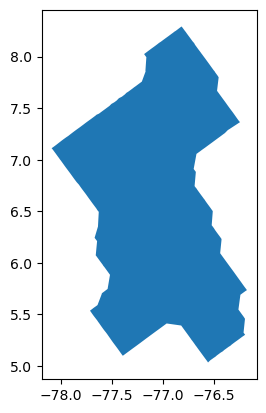

In [5]:
filename = output_dir + '/masks/mask_of_gravity_data.shp'
gdf_mask = gpd.read_file(filename)
gdf_mask.plot()

## DEM

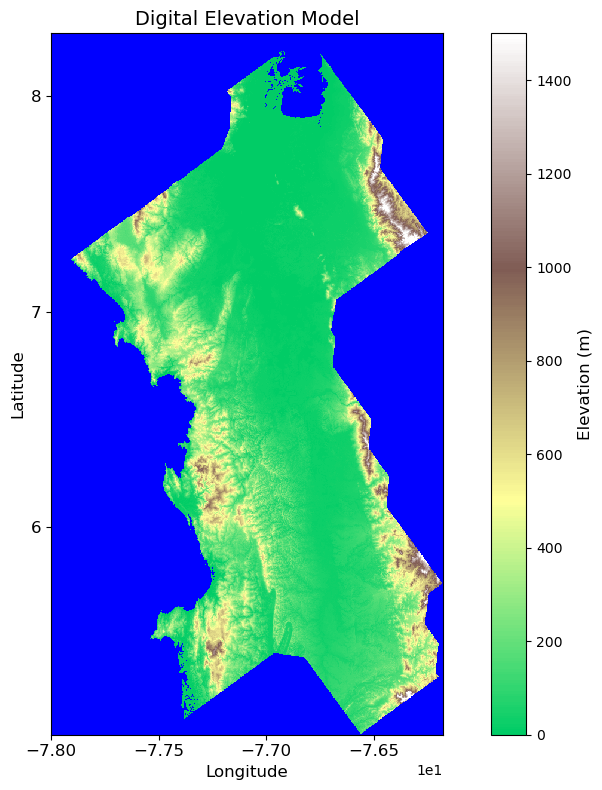

In [6]:
mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")  # ajusta si tu DEM usa otro CRS

dem_path = data_dir + '/DEM/combined_dem_pacifico.tif' # DTM taken from planetarycomputer.microsoft.com
topography = rioxarray.open_rasterio(dem_path)

topography_masked = topography.rio.clip(
    gdf_mask.geometry,
    gdf_mask.crs,
    drop=True,
    invert=False
)

raster_plotting.plot_raster_data(
    topography_masked.x, 
    topography_masked.y, 
    topography_masked[0],
    sampling=10,
    data_type='DEM', vmax=1500
)

In [7]:
topography_masked.rio.to_raster(output_dir + '/raster/atrato_basin/dem_masked_cg.tif')

In [8]:
region = (-77.7, -76.7, 7, 6)
topography_region = topography_masked.sel(x=slice(*region[:2]), y=slice(*region[2:]))
topography_region;

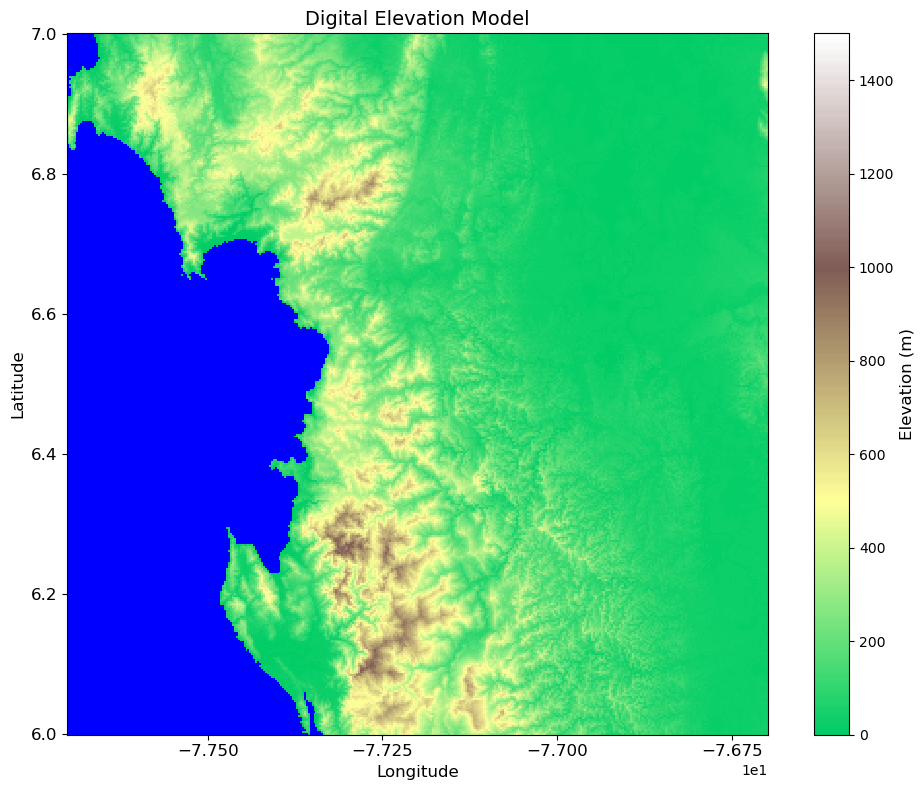

In [9]:
raster_plotting.plot_raster_data(topography_region.x, topography_region.y, topography_region[0], data_type='DEM', vmax=1500, sampling=10)

## Common Grid

In [10]:
x_values, y_values = topography_masked.x.values, topography_masked.y.values

In [11]:
display(Math(f"\\delta_x = {np.diff(topography_masked.x).mean():.6f},\\ \\delta_y = {np.diff(topography_masked.y).mean():.6f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

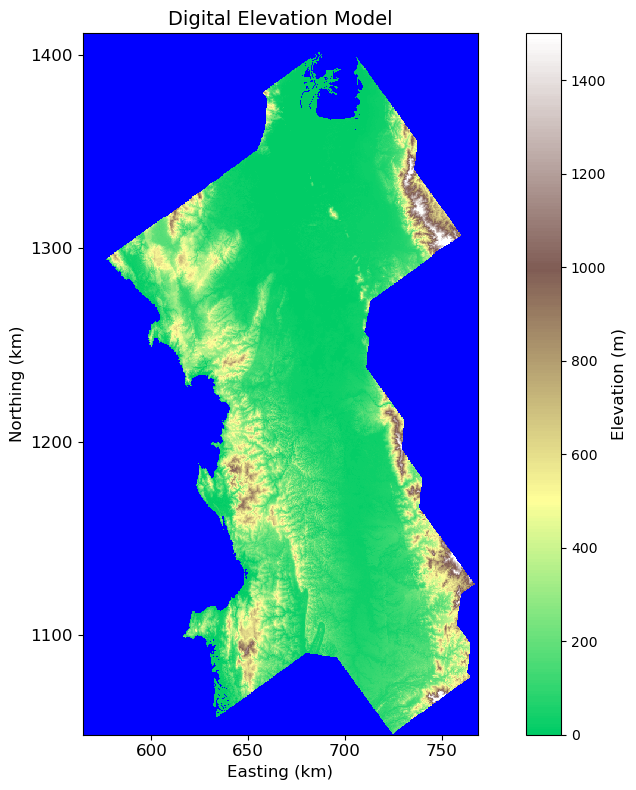

In [12]:
topography_crs_bogota = topography_masked.rio.reproject("EPSG:3116")
display(Math(f"\\delta_x = {np.diff(topography_crs_bogota.x).mean():.2f},\\ \\delta_y = {np.diff(topography_crs_bogota.y).mean():.2f}"))
raster_plotting.plot_raster_data(
    topography_crs_bogota.x/1e3, 
    topography_crs_bogota.y/1e3, 
    topography_crs_bogota[0], 
    data_type='DEM', 
    vmax= 1500,
    sampling=10
)
ax = plt.gca()
ax.set_xlabel('Easting (km)')
ax.set_ylabel('Northing (km)')
plt.show()

## Magnetic Data

In [13]:
line_str = 'line'
mag_types = {
    '/FID': int,
    'JDAY': int,
    'TIME': float,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'DIURNAL': float,
    'IGRF': float,
    'OBSMAG': float,
    'TMI_MAG': float,
    line_str: str
}

file_path = os.path.join(data_dir, 'magnetic/PAC_MAG_NORTE', 'PAC_MAG_NORTE.xyz')
magnetic = ascii_xyz.read_ascii_xyz(file_path, line_str, mag_types)
magnetic;

### Interpolate data with Spline

In [14]:
magnetic['anomaly'] = magnetic['IGRF'] - magnetic['OBSMAG']

In [15]:
values_interpolated = interpolate.interpolate_data_spline(magnetic, y_values, x_values, sampling_factor=100)

Number of points in data grid: 205243
Number of valid points for spline fitting: 2053


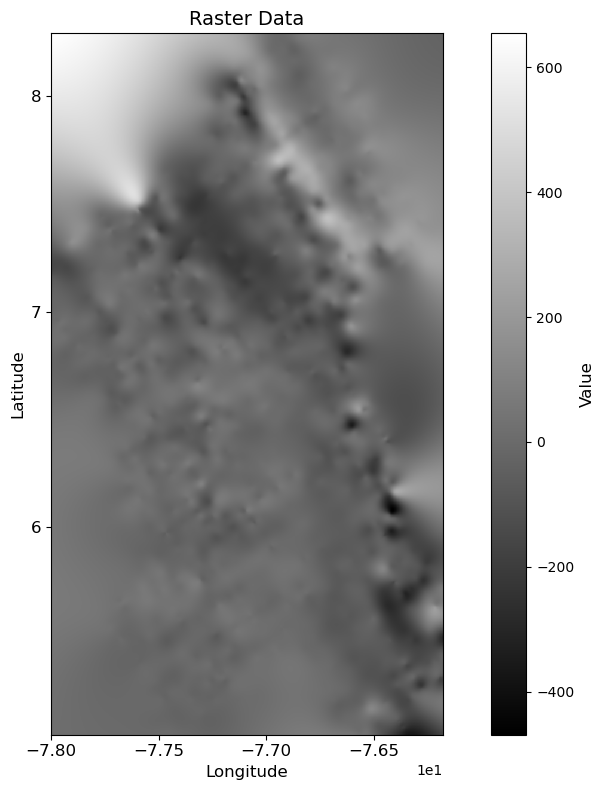

In [16]:
raster_plotting.plot_raster_data(x_values, y_values, values_interpolated, sampling=10)

In [44]:
values_data = values_interpolated

# ensure y_vec is from north to south
if y_values[0] < y_values[-1]:  # if first element is less than last, it's south to north
    values_data = np.flipud(values_data)
    y_values = y_values[::-1]

# DataArray
da = xr.DataArray(
    values_data,
    dims=("y", "x"),
    coords={"y": y_values, "x": x_values},
    name="TMI",
)
da = da.rio.write_crs("EPSG:4326")

# Save to GeoTIFF
out_path = os.path.join(output_dir, "raster", "magnetic_anomaly.tif")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
da.rio.to_raster(out_path, compress="LZW")

print(f"GeoTIFF saved at: {out_path}")

GeoTIFF saved at: c:\Users\jasolanoz\Documents\GitHub\lineament_detection\output\raster\magnetic_anomaly.tif


### Interpolate data with griddata

In [15]:
sampling = 10
magnetic_subsampled = magnetic.isel(index=slice(None, None, sampling))
grid_x, grid_y, data_interpolated, data_masked, inside_mask, shape = interpolate.interpolate_data(
    magnetic_subsampled, 
    var='TMI_MAG', 
    coords_type = ("long", "lat"), 
    alpha=10, return_shape=True,
    x_values=x_values,
    y_values=y_values
)

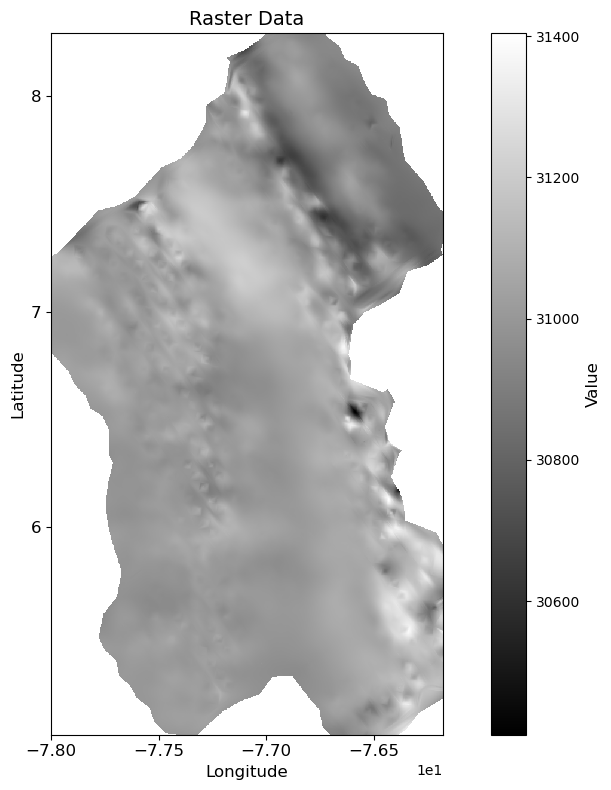

In [19]:
raster_plotting.plot_raster_data(x_values, y_values, data_masked.reshape(grid_x.shape), sampling=10)

In [20]:
# Mask
ny, nx = grid_x.shape
mask2d = np.asarray(data_masked).reshape(ny, nx)

# x and y vectors
x_vec = np.asarray(grid_x[0, :])
y_vec = np.asarray(grid_y[:, 0])

# ensure y_vec is from north to south
if y_vec[0] < y_vec[-1]:  # if first element is less than last, it's south to north
    mask2d = np.flipud(mask2d)
    y_vec = y_vec[::-1]

# DataArray
da = xr.DataArray(
    mask2d,
    dims=("y", "x"),
    coords={"y": y_vec, "x": x_vec},
    name="TMI",
)
da = da.rio.write_crs("EPSG:4326")

# Save to GeoTIFF
out_path = os.path.join(output_dir, "raster", "TMI_masked.tif")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
da.rio.to_raster(out_path, compress="LZW")

print(f"GeoTIFF saved at: {out_path}")

GeoTIFF saved at: c:\Users\jasolanoz\Documents\GitHub\lineament_detection\output\raster\TMI_masked.tif


### Mask

In [21]:
mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")

filename = os.path.join(output_dir, "raster", "TMI_masked.tif")
TMI = rioxarray.open_rasterio(filename)

TMI_masked = TMI.rio.clip(
    gdf_mask.geometry,
    gdf_mask.crs,
    drop=True,
    invert=False
)

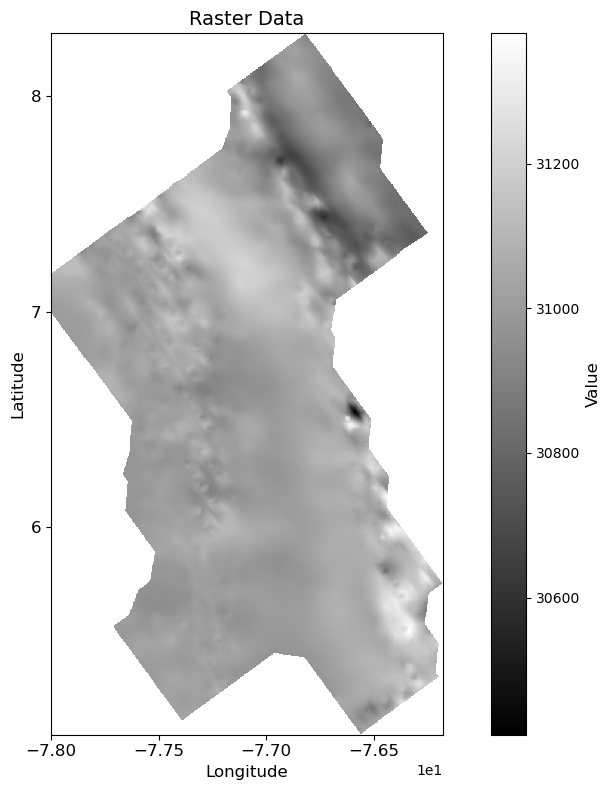

In [23]:
raster_plotting.plot_raster_data(TMI_masked.x, TMI_masked.y, TMI_masked[0], sampling=10)

In [9]:
TMI_masked.rio.to_raster(output_dir + '/raster/atrato_basin/TMI_masked_cg.tif')

## Gravity Data

In [48]:
line_str = 'line'
grav_types = {
    '/FID': int,
    'JDAY': int,
    'TIME': float,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'RAW_VERTACC': float,
    'RAW_BEAMDIFF': float,
    'ADJSPTEN': float,
    'FACORR': float,
    'LATCORR': float,
    'RAWEOTV': float,
    'FILT_EOTV': float,
    'FREEAIR': float,
    'TCOR230': float,
    'BOUG230': float,
    'TCOR267': float,
    'BOUG267': float,
    line_str: str
}

file_path = os.path.join(data_dir, 'gravity/PAC_GRAV_NORTE', 'PAC_GRAV_NORTE.xyz')
gravity = ascii_xyz.read_ascii_xyz(file_path, line_str, grav_types)
gravity;

In [50]:
sampling = 1
gravity_subsampled = gravity.isel(index=slice(None, None, sampling))
grid_x, grid_y, data_interpolated, data_masked, inside_mask, shape = interpolate.interpolate_data(
    gravity_subsampled, 
    var='BOUG230', 
    coords_type = ("long", "lat"), 
    alpha=10, return_shape=True,
    x_values=x_values,
    y_values=y_values
)

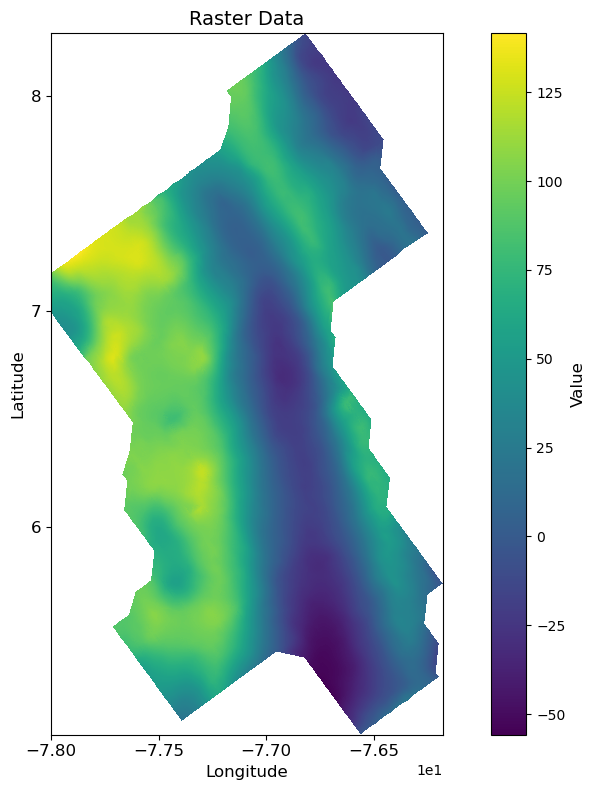

In [51]:
raster_plotting.plot_raster_data(grid_x, grid_y, data_masked.reshape(grid_x.shape), cmap = 'viridis')

In [ ]:
# Crear GeoTIFF de GRAV con Mascara
import numpy as np
import xarray as xr
import os

ny, nx = grid_x.shape
mask2d = np.asarray(data_masked).reshape(ny, nx)

x_vec = np.asarray(grid_x[0, :])
y_vec = np.asarray(grid_y[:, 0])

if y_vec[0] < y_vec[-1]:  # si está sur->norte, invertir
    mask2d = np.flipud(mask2d)
    y_vec = y_vec[::-1]

da = xr.DataArray(
    mask2d,
    dims=("y", "x"),
    coords={"y": y_vec, "x": x_vec},
    name="BOU",
)
da = da.rio.write_crs("EPSG:4326")

out_path = os.path.join(output_dir, "raster", "BOU_masked.tif")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
da.rio.to_raster(out_path, compress="LZW")

print(f"GeoTIFF guardado en: {out_path}")

GeoTIFF guardado en: c:\Users\jasolanoz\Documents\GitHub\lineament_detection\output\raster\BOU_masked.tif


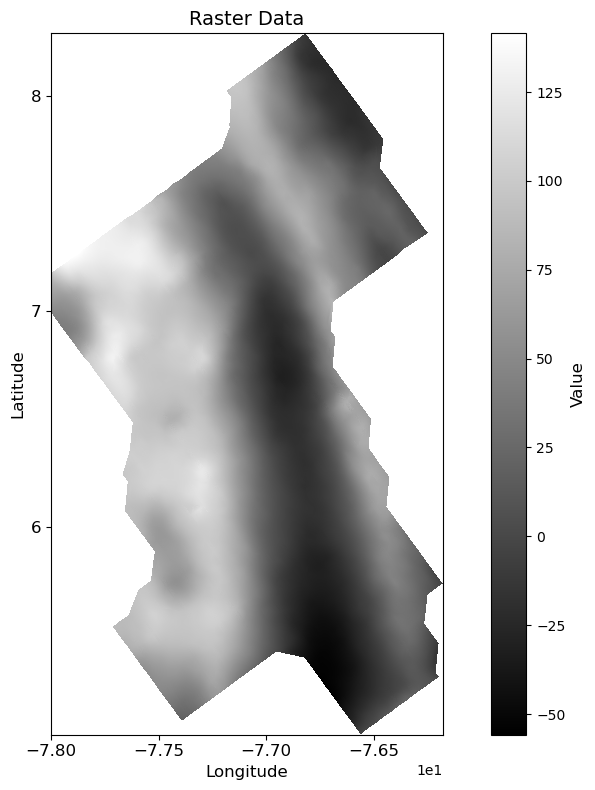

In [10]:
mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")

filename = os.path.join(output_dir, "raster", "BOU_masked.tif")
BOU = rioxarray.open_rasterio(filename)

BOU_masked = BOU.rio.clip(
    gdf_mask.geometry,
    gdf_mask.crs,
    drop=True,
    invert=False
)

raster_plotting.plot_raster_data(
    BOU_masked.x, BOU_masked.y, BOU_masked[0],
)

In [11]:
BOU_masked.rio.to_raster(output_dir + '/raster/atrato_basin/BOU_masked_cg.tif')

## SAR Data

In [ ]:
# filename = data_dir + '../../data/SAR/sentinel-1_GRD_VH.tif' # DTM taken from planetarycomputer.microsoft.com
filename = 'combined_SAR_vh_pacifico.tif'
file_path = data_dir + '/SAR/'+ filename # DTM taken from planetarycomputer.microsoft.com
SAR = rioxarray.open_rasterio(file_path)
SAR;

In [14]:
sampling = 5
SAR_sampled = SAR.isel(
    x=slice(None, None, sampling),
    y=slice(None, None, sampling)
)
SAR_sampled;

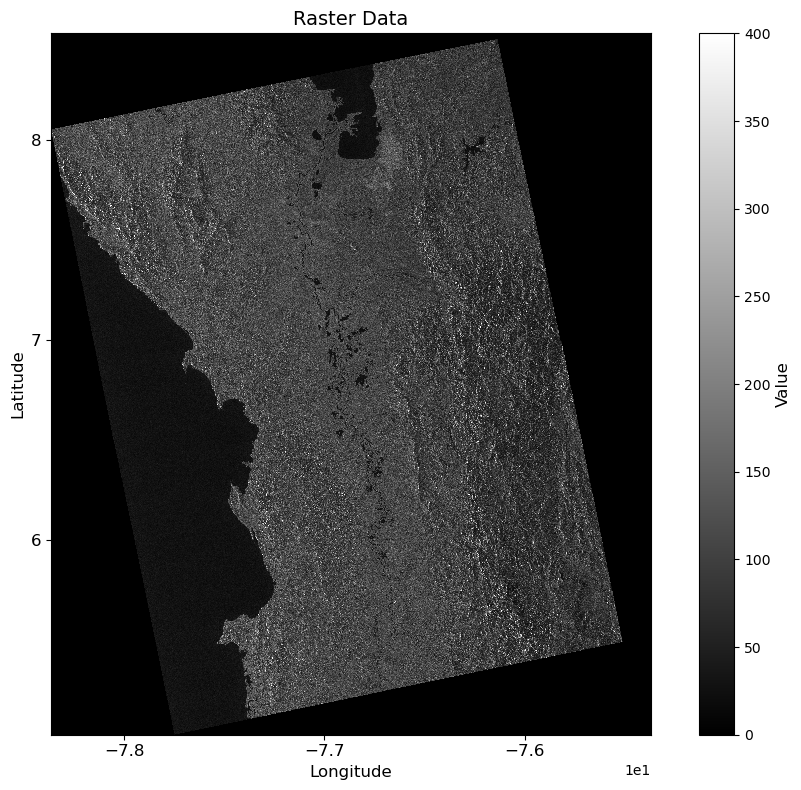

In [15]:
raster_plotting.plot_raster_data(SAR_sampled.x, SAR_sampled.y, SAR_sampled[0], vmax=400)

### Apply mask

In [ ]:
mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")

filename = os.path.join(data_dir, "SAR", filename)
SAR = rioxarray.open_rasterio(filename)
SAR;

In [27]:
if not SAR.rio.crs:
    SAR = SAR.rio.write_crs("EPSG:4326")
if not topography_masked.rio.crs:
    topography_masked = topography_masked.rio.write_crs("EPSG:4326")

template = xr.DataArray(
    np.empty((len(y_values), len(x_values))),
    dims=("y","x"),
    coords={"y": y_values, "x": x_values}
).rio.write_crs(topography_masked.rio.crs)

SAR_resampled = SAR.rio.reproject_match(template)

In [28]:
SAR_masked = SAR_resampled.rio.clip(
    gdf_mask.geometry,
    gdf_mask.crs,
    drop=True,
    invert=False
)

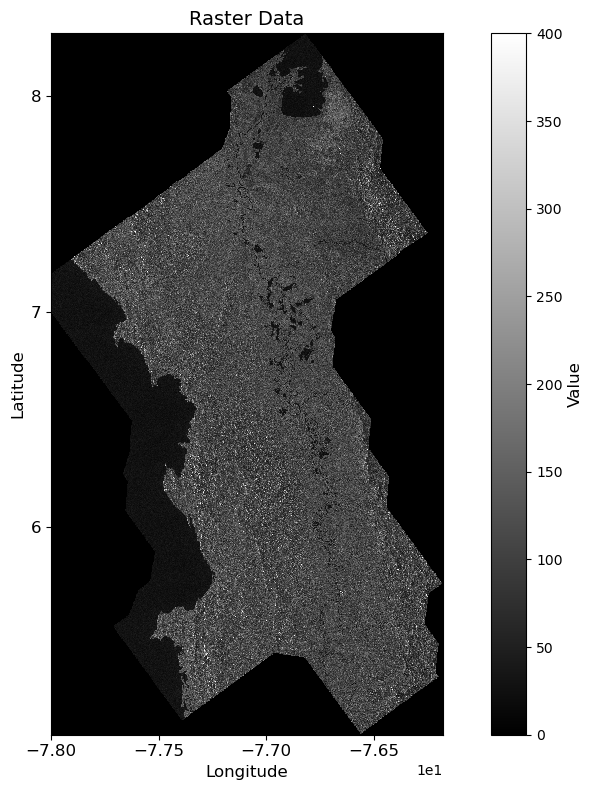

In [18]:
sampling = 10
SAR_sampled_masked = SAR_masked.isel(
    x=slice(None, None, sampling),
    y=slice(None, None, sampling)
)

raster_plotting.plot_raster_data(
    SAR_sampled_masked.x, SAR_sampled_masked.y, SAR_sampled_masked[0], vmax=400
)

In [29]:
SAR_masked.rio.to_raster(output_dir + '/raster/' + f'combined_SAR_vh_pacifico_masked.tif')

### Speckle Filter (SNAP ESA)

In [ ]:
filename = output_dir + '/raster/' + 'combined_SAR_vh_pacifico_masked_spk_cg.tif' # DTM taken from planetarycomputer.microsoft.com
SAR = rioxarray.open_rasterio(filename)
SAR;

In [7]:
sampling = 10
SAR_subsampled = SAR.isel(
    x=slice(None, None, sampling),
    y=slice(None, None, sampling)
)

# region = (-77.7, -76.7, 7, 6)
# SAR_subsampled = SAR_subsampled.sel(x=slice(*region[:2]), y=slice(*region[2:]))

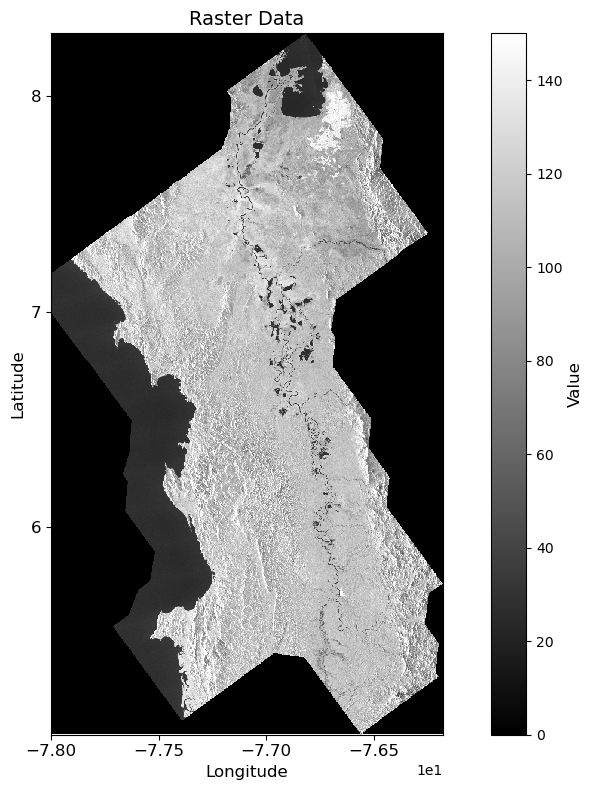

In [8]:
raster_plotting.plot_raster_data(SAR_subsampled.x, SAR_subsampled.y, SAR_subsampled[0], vmax=150)

## Only one tiff

In [ ]:
BOU = rioxarray.open_rasterio(output_dir + '/raster/atrato_basin/BOU_residual_smoothed_gaussian_sigma_10.tif')
gradient = rioxarray.open_rasterio(output_dir + '/raster/atrato_basin/BOU_grad_mag_np.tif')
TMI = rioxarray.open_rasterio(output_dir + '/raster/atrato_basin/TMI_masked_cg.tif')
DEM = rioxarray.open_rasterio(output_dir + '/raster/atrato_basin/dem_masked_cg.tif')
SAR_VH = rioxarray.open_rasterio(output_dir + '/raster/atrato_basin/combined_SAR_vh_pacifico_masked_spk_cg.tif')

for da in (BOU, gradient, TMI, DEM, SAR_VH):
    if not da.rio.crs:
        da = da.rio.write_crs("EPSG:4326")

# Usar DEM como plantilla de grilla
template = DEM[0] if "band" in DEM.dims else DEM

# Reproyectar/ajustar cada raster a la plantilla
BOU_aligned = BOU[0].rio.reproject_match(template)
gradient_aligned = gradient[0].rio.reproject_match(template)
TMI_aligned = TMI[0].rio.reproject_match(template)
DEM_aligned = DEM[0].rio.reproject_match(template)
SAR_aligned = SAR_VH[0].rio.reproject_match(template)

for da in (BOU_aligned, gradient_aligned, TMI_aligned, DEM_aligned, SAR_aligned):
    if "x" not in da.dims or "y" not in da.dims:
        da = da.rename({"longitude": "x", "latitude": "y"})

ds = xr.Dataset(
    {
        "BOU": (("y","x"), BOU_aligned.values),
        "GRADIENT": (("y","x"), gradient_aligned.values),
        "TMI": (("y","x"), TMI_aligned.values),
        "DEM": (("y","x"), DEM_aligned.values),
        "SAR_VH": (("y","x"), SAR_aligned.values),
    },
    coords={"x": template.x, "y": template.y}
)

out_tif = os.path.join(output_dir, "raster", "atrato_basin", "stack_5bands.tif")
stack = xr.concat([BOU_aligned, gradient_aligned, TMI_aligned, DEM_aligned, SAR_aligned], dim="band")
stack = stack.assign_coords(band=[1,2,3,4,5])
stack.rio.to_raster(out_tif)
print(f"GeoTIFF multibanda guardado en: {out_tif}")

GeoTIFF multibanda guardado en: c:\Users\jasolanoz\Documents\GitHub\lineament_detection\output\raster\atrato_basin\stack_5bands.tif


In [5]:
file_path = os.path.join(output_dir, "raster", "atrato_basin", "stack_5bands.tif")
stack = rioxarray.open_rasterio(file_path)

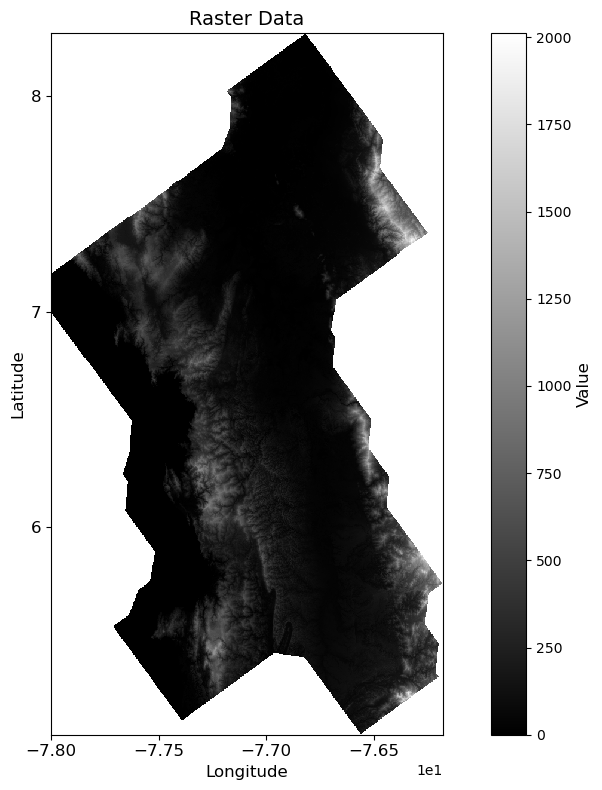

In [6]:
raster_plotting.plot_raster_data(stack.x, stack.y, stack[3], sampling=10)

## Geology Map

In [7]:
gdf = gpd.read_file(r"..\data\vector\geoColombia\Mapa_Geol%C3%B3gico_de_Colombia_2015._Escala_1%3A1.000.000.shp")
gdf = gdf.to_crs("EPSG:4326")
gdf

,OBJECTID,Tipo,NombreFall,Comentario,GlobalID,Shape__Len,geometry
0,13687,Falla,None,None,525f310a-5944-4c95-b958-c91e6d6f4d27,0.139363,"LINESTRING (-72.89873 6.34496, -72.89316 6.344..."
1,13690,Falla,Falla de Chaguaca,None,ac1c2068-f814-4261-96f1-07511a569a35,0.013992,"LINESTRING (-72.77309 6.17363, -72.77141 6.165..."
2,13691,Falla,Falla de Chaguaca,None,07eeeda1-ec6d-4b89-839e-6c6e446000b4,0.157835,"LINESTRING (-72.81564 5.98508, -72.81506 5.986..."
3,13692,Falla inversa o de cabalgamiento,Falla de Soápaga,None,14dbf299-4126-4d94-b6ca-902c97ad5a27,0.084160,"LINESTRING (-72.71945 6.11084, -72.71961 6.104..."
4,13693,Falla cubierta,Falla de Soápaga,None,3320158f-fc99-47f7-b9c2-4eb4986905b4,0.031333,"LINESTRING (-72.66563 6.1713, -72.6676 6.16892..."
...,...,...,...,...,...,...,...
4861,23921,Falla,None,None,fb1a8c85-7d7e-404c-8b2f-21cbe65cd65c,0.023447,"LINESTRING (-73.37392 4.36841, -73.37463 4.360..."
4862,23922,Falla inversa o de cabalgamiento,None,None,ac659b84-1188-4b63-9b50-7953cd7a6baa,0.073274,"LINESTRING (-72.68795 5.00243, -72.69093 4.997..."
4863,23923,Falla inversa o de cabalgamiento cubierta,None,None,c197b7f7-ecc4-4b36-b79c-cec5ecdf55fd,0.007457,"LINESTRING (-72.72966 4.94265, -72.73032 4.941..."
4864,23924,Falla,None,None,7a8ca6f2-2506-41fc-850f-60f824d3c07a,0.009036,"LINESTRING (-73.52957 4.3542, -73.53181 4.3563..."


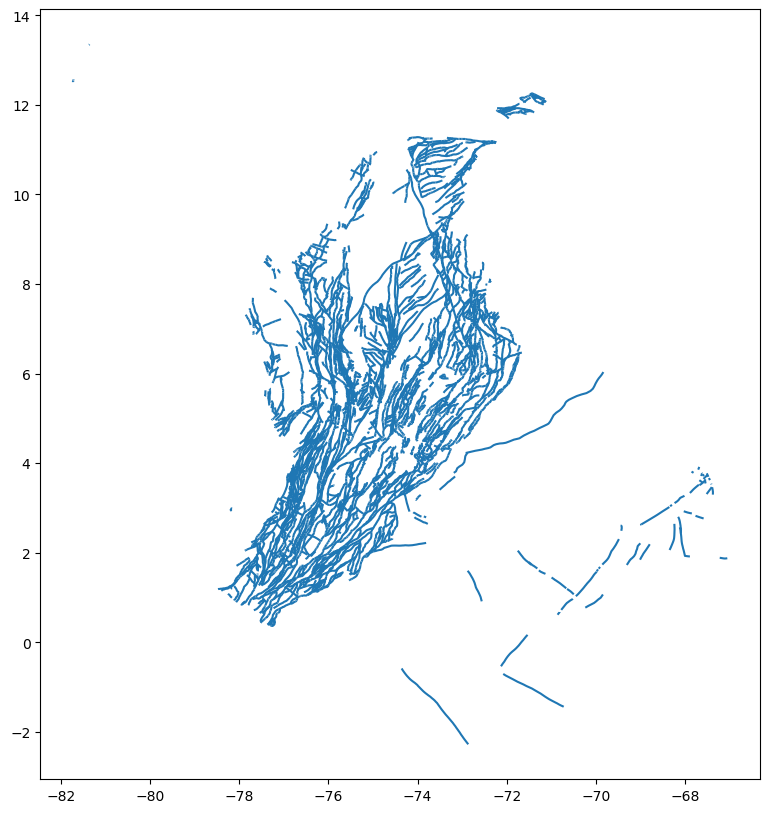

In [8]:
gdf.plot(figsize=(10,10))
ax = plt.gca()
plt.show()

In [9]:
mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")

gdf_geology = gpd.clip(gdf, gdf_mask.geometry)

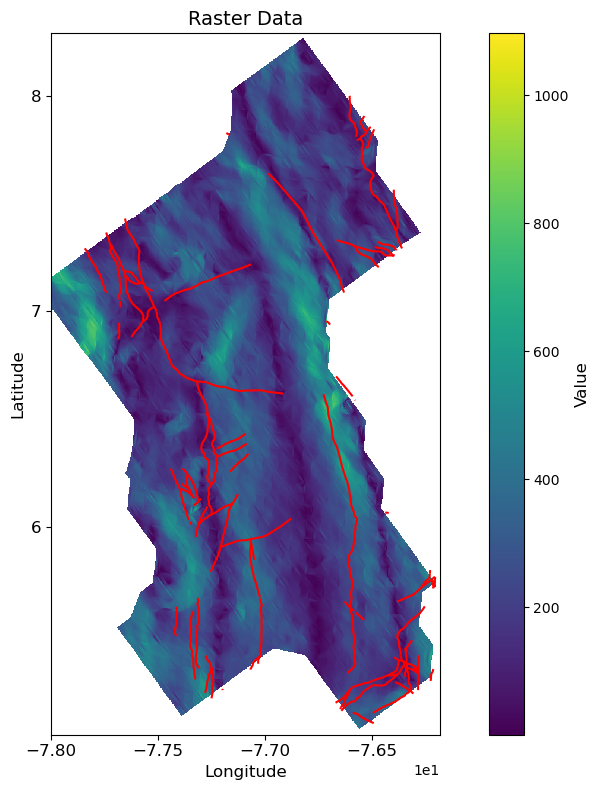

In [13]:
raster_plotting.plot_raster_data(stack.x, stack.y, stack[1], sampling=10, cmap='viridis')
ax = plt.gca()
gdf_geology.plot(ax=ax, figsize=(10,10), edgecolor='red')
ax.set_xlim(stack.x.min(), stack.x.max())
ax.set_ylim(stack.y.min(), stack.y.max())
# region = (
#     -77.0, -76.5, 7, 7.5
# )
# ax.set_xlim(region[0], region[1])
# ax.set_ylim(region[2], region[3])
plt.show()

In [11]:
# Guardar como Shapefile
output_path = os.path.join(output_dir, "vector", "pacifico_map_geo_masked.shp")
gdf_geology.to_file(output_path, driver="ESRI Shapefile")
print(f"Shapefile guardado en: {output_path}")

Shapefile guardado en: c:\Users\jasolanoz\Documents\GitHub\lineament_detection\output\vector\pacifico_map_geo_masked.shp


### Planchas

<Axes: >

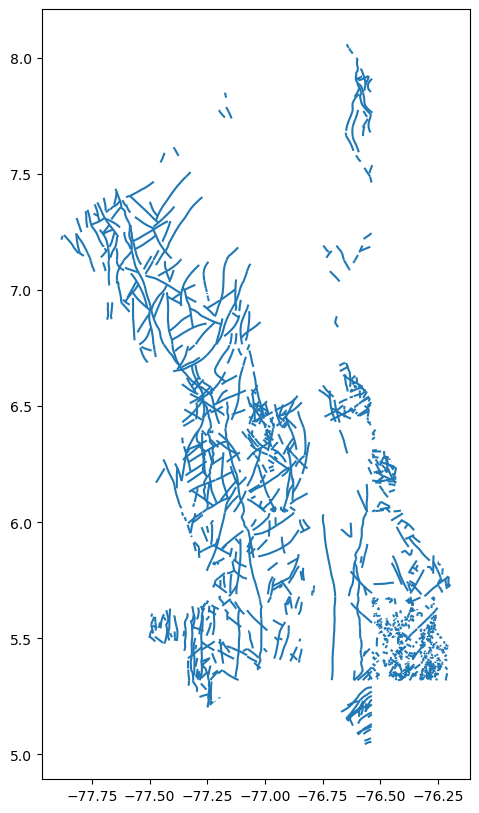

In [44]:
file_path = output_dir + r'\vector\pacifico_structures.shp'
gdf_structures = gpd.read_file(file_path)
gdf_structures = gdf_structures.to_crs("EPSG:4326")

mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")

gdf_geology = gpd.clip(gdf_structures, gdf_mask.geometry)
gdf_geology.plot(figsize=(10,10))

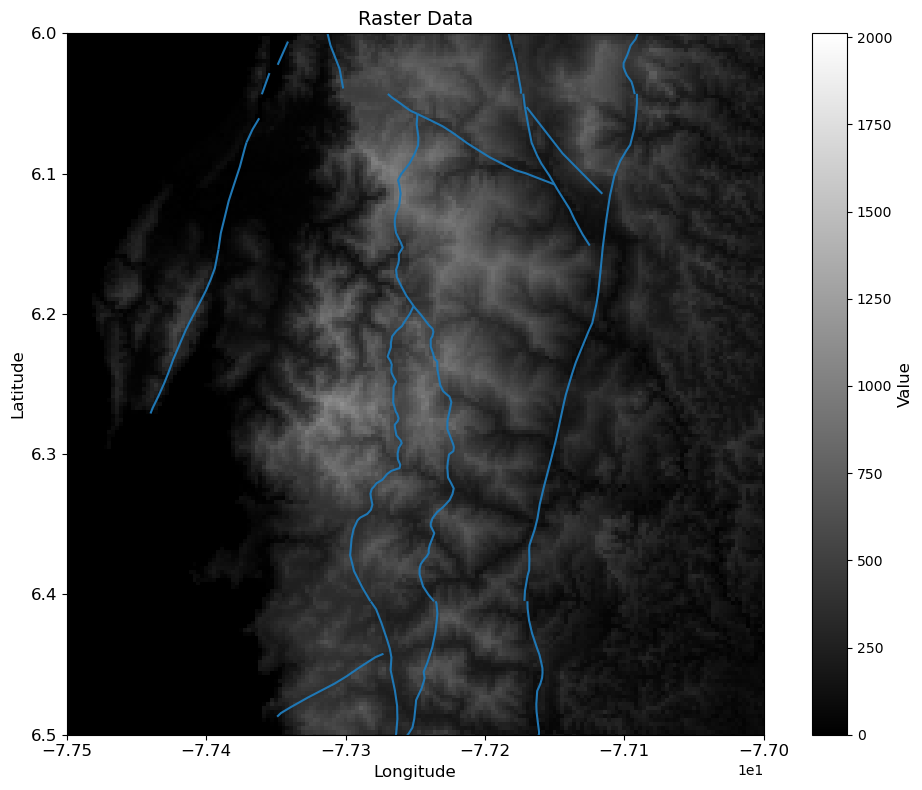

In [45]:
raster_plotting.plot_raster_data(stack.x, stack.y, stack[3], sampling=10)
ax = plt.gca()
gdf_geology[gdf_geology['Name']== "Fallas"].plot(ax=ax, figsize=(10,10))
# ax.set_xlim(stack.x.min(), stack.x.max())
# ax.set_ylim(stack.y.min(), stack.y.max())
region = (
    -77.5, -77.0, 6.5, 6
)
ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])
plt.show()

In [64]:
output_path = os.path.join(output_dir, "vector", "pacifico_estructures_masked.shp")
gdf_geology.to_file(output_path, driver="ESRI Shapefile")
print(f"Shapefile guardado en: {output_path}")

Shapefile guardado en: c:\Users\jasolanoz\Documents\GitHub\lineament_detection\output\vector\pacifico_estructures_masked.shp


c:\Users\jasolanoz\AppData\Local\anaconda3\envs\lineament-detection\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field timestamp create as date field, though DateTime requested.
  ogr_write(
c:\Users\jasolanoz\AppData\Local\anaconda3\envs\lineament-detection\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field begin create as date field, though DateTime requested.
  ogr_write(
c:\Users\jasolanoz\AppData\Local\anaconda3\envs\lineament-detection\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Field end create as date field, though DateTime requested.
  ogr_write(


## Geology Estructures to raster

In [ ]:
import rasterio
from rasterio import features

file_path = os.path.join(output_dir, "vector", "pacifico_map_geo_masked.shp")
gdff = gpd.read_file(file_path)

raster_path = output_dir + '/raster/' + r'\atrato_basin\stack_5bands.tif'
output_tiff = output_dir + '/raster/' +  r'\atrato_basin\pacifico_map_geo_masked.tif'

with rasterio.open(raster_path) as raster:
    raster_meta = raster.meta.copy()
    transform = raster.transform
    out_shape = (raster.height, raster.width)
    crs = raster.crs
    pixel_size = raster.res[0]


In [ ]:
gdf = gdf.to_crs(crs)
buffer_m = pixel_size * 1.5
gdf["geometry"] = gdf.geometry.buffer(buffer_m)

tipo_mapping = {"lineamiento":1, "falla":2, "pliegue":3}
line_shapes = ((row.geometry, tipo_mapping[row.tipo]) for idx, row in gdf.iterrows())
line_shapes = ((geom, 1) for geom in gdf.geometry)

rasterized = features.rasterize(
    shapes=line_shapes,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)
raster_meta.update({
    "count": 1,
    "dtype": "float32",
    "nodata": 0
})

from skimage.filters import gaussian
sigma = 0.8
broadened_structures = gaussian(rasterized.astype(float), sigma=sigma, preserve_range=True)

with rasterio.open(output_tiff, "w", **raster_meta) as dst:
    dst.write(broadened_structures, 1)
import matplotlib.pyplot as plt


C:\Users\jasolanoz\AppData\Local\Temp\ipykernel_58752\2098352354.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"] = gdf.geometry.buffer(buffer_m)


### Combine Structures and GeoData

In [ ]:
import xarray as xr
import rioxarray

# Archivos de entrada
tiff1 = output_dir + '/raster/' +  r'\atrato_basin\pacifico_map_geo_masked.tif'
tiff2 = output_dir + '/raster/' + r'\atrato_basin\stack_5bands.tif'
output_tiff = output_dir + '/raster/' +  r'\atrato_basin\pacifico_data_merged.tif'

# Abrir los TIFFs como DataArray
da1 = rioxarray.open_rasterio(tiff1)  # shape: (bands, y, x)
da2 = rioxarray.open_rasterio(tiff2)

# Verificar alineamiento
if not da1.rio.crs == da2.rio.crs:
    raise ValueError("Los TIFFs no tienen el mismo CRS")
if not da1.rio.transform() == da2.rio.transform():
    raise ValueError("Los TIFFs no están alineados")

# Concatenar en la dimensión de bandas
stacked = xr.concat([da1, da2], dim="band")

# Guardar como nuevo TIFF
stacked.rio.to_raster(output_tiff)

print(f"TIFF apilado guardado como: {output_tiff}")

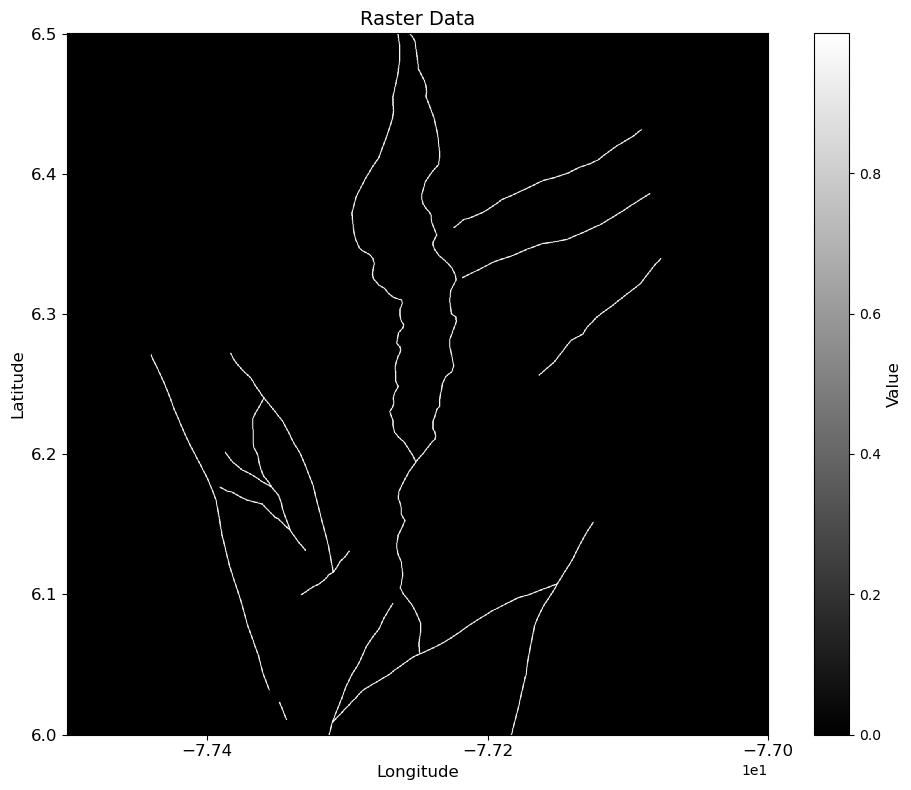

In [27]:
file_path = output_dir + '/raster/' +  r'\atrato_basin\pacifico_data_merged.tif'
data_stack = rioxarray.open_rasterio(file_path)

region = (
    -77.5, -77.0, 6.5, 6
)
data_stack = data_stack.sel(
    x=slice(*region[:2]),
    y=slice(*region[2:]),
)
raster_plotting.plot_raster_data(data_stack.x, data_stack.y, data_stack[0], sampling=1)